# Assignment 2
## Clustering using K-Means 
### Group Members
>- Bilal Ahmed - _C0803540_
>- Devi Priyanka Kanakamedala - *C0805095*
>- Rohit Kumar Vadlamudi - *C0804966*



##  Importing Libraries and Modules
We imported packages listed below

>- **pandas, numpy,** and **scipy** to effectively manipulate large dataset.
>- **matplotlib,** and **seaborn** for data visualization.
>- **sklearn** methods for building the machine learning model. 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
import seaborn as sb
from pylab import rcParams

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report,roc_curve,auc

%matplotlib inline
sb.set(font_scale=1.1)
sb.set_style("dark")

### About Dataset - *Cancer.csv*
- This database contains **11 attributes** including target class. 
- These relates to the presence of cancer tissue in a person and various conditions in this tissue development.It has the folowing features
>- Clump Thickness
>- UofCSize             
>- UofCShape            
>- Marginal Adhesion    
>- SECSize              
>- Bare Nuclei          
>- Bland Chromatin      
>- Normal Nucleoli      
>- Mitoses              
>- Class 


The "class" field refers to the kind of tissue or tumor, **benign** or **malignant** both represented by an integer 

In [2]:
df = pd.read_csv("cancer.csv") # Reading CSV
df.head()

,id,Clump Thickness,UofCSize,UofCShape,Marginal Adhesion,SECSize,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


**1.** Dropping **id** column as it's not feature<br>
**2.** Mapping **Class** column replacing 2 and 4 with 0 and 1 for our ease.
>- benign = 0<br>
>- malignant = 1

In [3]:
df.drop('id', axis=1, inplace=True)         # Droping the ID column 
df["Class"] = df['Class'].map({2:0,4:1})    # Replacing the values in "class" column with 0 and 1 

class_names = ['benign', 'malignant']

print("Target Class Names:",class_names)
print("Target Class values",df["Class"].unique())
print("Shape of data:",df.shape)

Target Class Names: ['benign', 'malignant']
Target Class values [0 1]
Shape of data: (683, 10)


- Finding null values in dataset using **isnull()** method
- Checking datatypes of features using **info()** method

In [4]:
print(df.isnull().sum(),"\n\n")    # Finding null value count
df.info()

Clump Thickness      0
UofCSize             0
UofCShape            0
Marginal Adhesion    0
SECSize              0
Bare Nuclei          0
Bland Chromatin      0
Normal Nucleoli      0
Mitoses              0
Class                0
dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Clump Thickness    683 non-null    int64
 1   UofCSize           683 non-null    int64
 2   UofCShape          683 non-null    int64
 3   Marginal Adhesion  683 non-null    int64
 4   SECSize            683 non-null    int64
 5   Bare Nuclei        683 non-null    int64
 6   Bland Chromatin    683 non-null    int64
 7   Normal Nucleoli    683 non-null    int64
 8   Mitoses            683 non-null    int64
 9   Class              683 non-null    int64
dtypes: int64(10)
memory usage: 53.5 KB


Dropping **Mitoses** because it is highly postive skewed feature which could have negative effect on our clustering as it's not fullfiling K-means model assumptions.

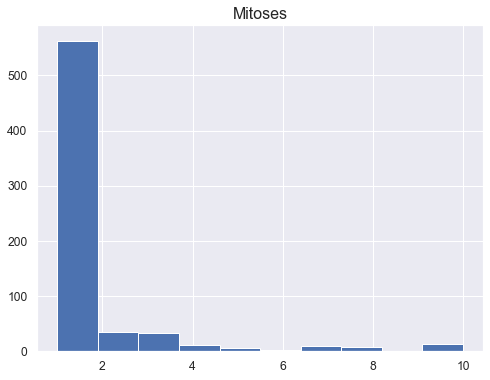

In [5]:
plt.figure(figsize=(8,6))    
df["Mitoses"].hist(bins=10);  # histogram for the column 'Mitoses'
plt.title("Mitoses",fontsize=16);

In [6]:
df.drop('Mitoses', axis=1, inplace=True)     # Droping Mitoses column
feature_names = list(df.columns)[:-1]        # Getting features list except target column

print("Data shape after dropping:",df.shape)
print("Features  List: ",feature_names)

Data shape after dropping: (683, 9)
Features  List:  ['Clump Thickness', 'UofCSize', 'UofCShape', 'Marginal Adhesion', 'SECSize', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli']


# Model Assumptions (K-means)
1. Data has no outliers
2. Data has symmetric distribution (Gaussian/Normal)
3. Data is not correlated
4. Data is on same scale
5. Few number of dimensions


### 1. Removing outliers
- As all feature values are categolrical so there will be no outlier but still we will check outliers using **describe()** method.
- It shows that all features ranging from 1 to 10 and there are not unexpected extreme values in data.

In [7]:
df.describe()

,Clump Thickness,UofCSize,UofCShape,Marginal Adhesion,SECSize,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,0.349927
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,0.477296
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


### 2. Checking Distributions 

- The simple plot used to check the distribution of a sample of data is histogram.
- Clustering of data is not possible in histogram
- The data is divided into pre specified number of groups called bins.
- The data is sorted into each bin and the count of the number of observations in each bin is retained.

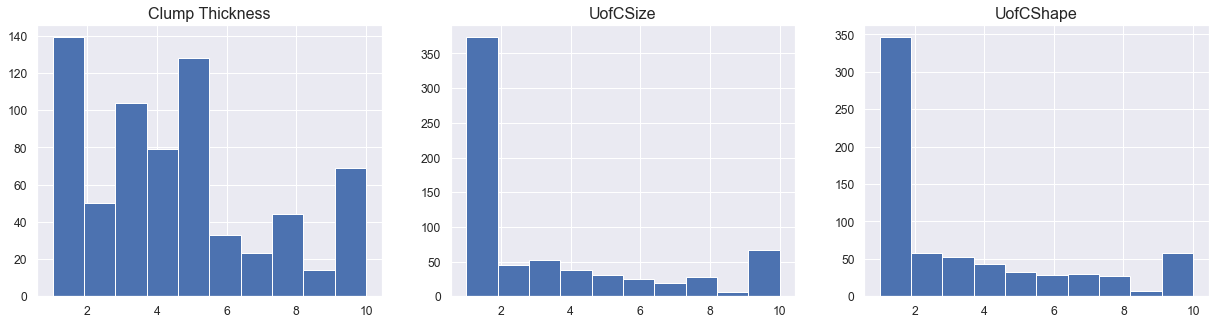

In [8]:
plt.figure(figsize=(21,5))

for i in range(0,3):                        # Plotting histogram of features  
    plt.subplot(1,3,i+1)
    df[feature_names[i]].hist(bins=10)
    plt.title(feature_names[i], fontsize=16);

### 3. Correlation Check
- Spearman test is used to check correlation between categorical variables
- It's value ranges for -1 to 1
>- If value is near to -1 it reflects **-ive** correlation
>- If value is near to 0 it reflects **no** correlation
>- if value is near 1 it reflects **+ive** correlation

In [9]:
spearmanr_coeff, _ = spearmanr(df["Clump Thickness"], df["Marginal Adhesion"])
print(f"SpearmanR Coefficient value is {spearmanr_coeff:.3f} between 'Clump Thickness' & 'Marginal Adhesion'")

spearmanr_coeff, _ = spearmanr(df["SECSize"], df["Bland Chromatin"])
print(f"\nSpearmanR Coefficient value is {spearmanr_coeff:.3f} between 'SECSize' & 'Bland Chromatin'")

spearmanr_coeff, _ = spearmanr(df["Normal Nucleoli"], df["Bare Nuclei"])
print(f"\nSpearmanR Coefficient value is {spearmanr_coeff:.3f} between 'Normal Nucleoli' & 'Bare Nuclei'")

SpearmanR Coefficient value is 0.544 between 'Clump Thickness' & 'Marginal Adhesion'

SpearmanR Coefficient value is 0.645 between 'SECSize' & 'Bland Chromatin'

SpearmanR Coefficient value is 0.660 between 'Normal Nucleoli' & 'Bare Nuclei'


### 4. Scaling Features
- MinMax Scalar is most common feature scaling algorithm.
- This estimator scales and translates each feature individually.
- In this approach, the data is scaled to a fixed range between 0 to 1.

In [10]:
y = df.pop("Class")                             # Removing target labels
X = MinMaxScaler().fit_transform(df.values)     # Scaling data with minmax scalar 

print("Shape of data:",X.shape)
print("Shape of target label:",y.shape)

print("\nMinimum value of all columns:",X.min(axis=0))
print("maximum value of all columns:",X.max(axis=0))

Shape of data: (683, 8)
Shape of target label: (683,)

Minimum value of all columns: [0. 0. 0. 0. 0. 0. 0. 0.]
maximum value of all columns: [1. 1. 1. 1. 1. 1. 1. 1.]


### 5. Reducing Dimensions
- Data has curse of dimentionality which means high dimension data for clustering problem.<br>
- We will reduced our data to 2D using **t-sne** algorithm.
- Low dimentional data is assumption of clustering algorithms & also provide better visualisation.
- There are other dimension reduction algorithms as well such as **Principal Component Analysis (PCA)** and many more.

In [11]:
print("Dimension of data before t-sne:",X.shape)

tsne = TSNE(n_components=2, perplexity=40, n_iter=4000, random_state=786)
X = tsne.fit_transform(X)

print("Dimension of data after t-sne:",X.shape)

Dimension of data before t-sne: (683, 8)
Dimension of data after t-sne: (683, 2)


## Visualising Data
- Data visualization refers to visual representation of information and data.
- We used scatter plot for clusters visualization, **Yellow** and **Red** colors respresent **_benign_** and **_malignant_** respectively.

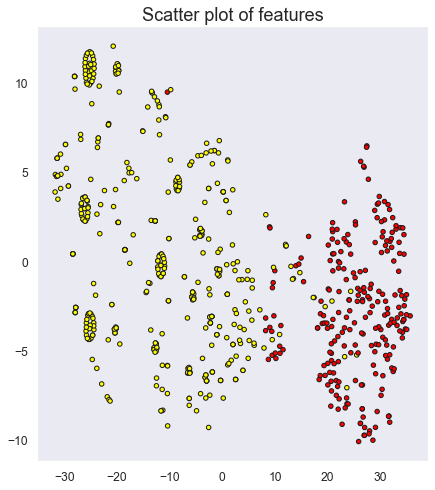

In [12]:
colors = np.array(['yellow','red'])                     # Setting colors for clusters
plt.figure(figsize=(7,8));

plt.scatter(X[:,0], X[:,1], c=colors[y],                # Scatter plot of data 
            cmap='gist_rainbow', edgecolor='k', s=20);
plt.title("Scatter plot of features",fontsize=18);

## Clustering Data
- Clustering is an unsupervised problem of finding natural groups in the feature space of input data.
- There are many different clustering algorithms and no single best method for all datasets.
- Usually algorithms it cluster data on distance between data points.

In [13]:
kmeans = KMeans(n_clusters=2, random_state=786)        # Initialising K-measn model
kmeans.fit(X)                                          # Creating clusters of data 
kmeans

KMeans(n_clusters=2, random_state=786)

## Centroids & Prediction
Displaying cluster center values and first 20 predicted values

In [14]:
cluster_centers = kmeans.cluster_centers_
y_pred = kmeans.labels_

print("Cluster center values:\n",cluster_centers)
print("\nLabels assigned by K-means:\n",y_pred[0:20])

Cluster center values:
 [[-13.453642    0.9284509]
 [ 24.077194   -2.7345679]]

Labels assigned by K-means:
 [0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0]


## Ploting actual and clustered data with centroids
You may notice after clustering color labels are swapped<br>
Triangles in blues represent centroids

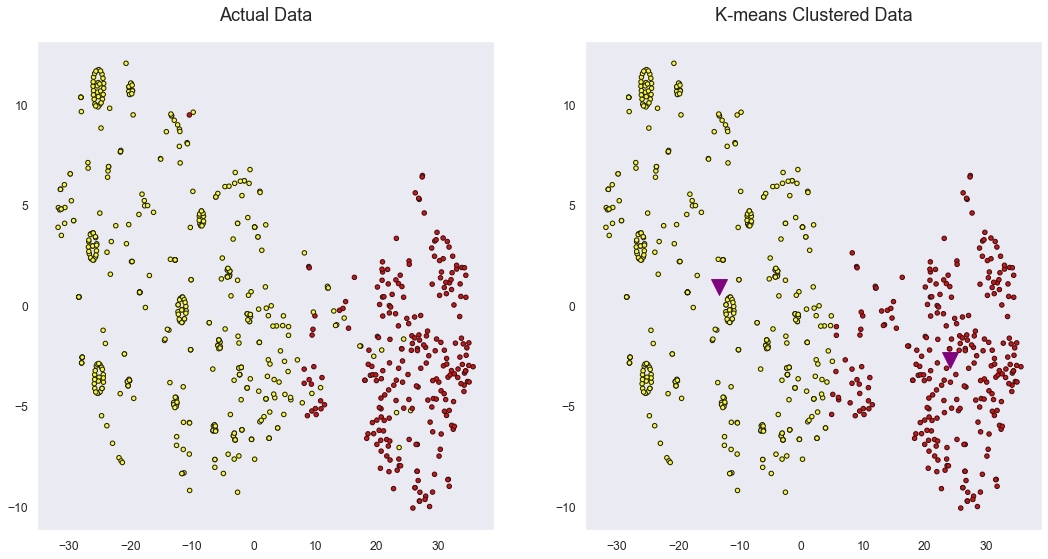

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(18,9))
axes[0].scatter(X[:, 0], X[:, 1], c=colors[y], edgecolor='k', s=20);
axes[1].scatter(X[:, 0], X[:, 1], c=colors[y_pred], edgecolor='k', s=20);
axes[1].scatter(cluster_centers[:,0], cluster_centers[:,1],s=250,c='purple',marker="v");

axes[0].set_title('Actual Data', fontsize=18, y=1.03);
axes[1].set_title('K-means Clustered Data', fontsize=18, y=1.03);

## Confusion Matrix
Confusion matrix is a great way of demonstarting the outcome of a classifier. When we have two outcomes, confusion matrix shows the result by plotting the data of predicted values with actual values.<br><br> Confusion matrix has the keywords <br>
<img style="float: right;" alt="img not found" src="con.jpg" width=600 height=600>
- **True positive (TP):** Predected yes when actual was yes
- **True negative (TN):** Predected no when actual was no
- **False positive (FP):** Predected yes when actual was no
- **False negative (FN):** Predected no when actual was yes

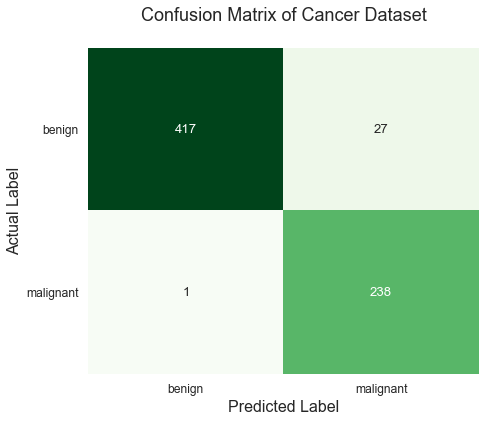

In [16]:
plt.figure(figsize=(7,6))           

# Plotting a confusion matrix
g = sb.heatmap(confusion_matrix(y, y_pred),                   
                   xticklabels=class_names,
                   yticklabels=class_names,
                   annot=True, cmap="Greens",
                   fmt="",cbar=False);          

g.set_yticklabels(g.get_yticklabels(), rotation = 0)

plt.xlabel('Predicted Label',fontsize=16);
plt.ylabel('Actual Label',fontsize=16);

plt.title("Confusion Matrix of Cancer Dataset\n", fontsize=18);

## Classification report
Classification report is used to measure the quality of predictions from algorithm. It displays precision, recall and F1-scores of model on perdicted data.
- **Precision:** Refers to the percentage of your results which are relevant.
- **Recall:** Refers to the percentage of total relevant results correctly classified by your algorithm. 
- **F1-Score:** It is the _harmonic mean_ of the model's precision and recall.
<br> $\;\;\;\;\;\;$
$Precision = \frac{\text{True Positive}}{\text{True Positive } + \text{ False Positive}}$ $\;\;\;\;\;\;$ $Recall = \frac{\text{True Positive}}{\text{True Positive } + \text{ False Negative}}$
<br><br> $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$  $F_{1} Score = \frac{\text{Precision } \times \text{ Recall}}{\text{Precision } + \text{ Recall}}$



In [17]:
print(classification_report(y, y_pred,
                            target_names=class_names))

              precision    recall  f1-score   support

      benign       1.00      0.94      0.97       444
   malignant       0.90      1.00      0.94       239

    accuracy                           0.96       683
   macro avg       0.95      0.97      0.96       683
weighted avg       0.96      0.96      0.96       683



## ROC Curve
- ROC stands for Receiver Operating Characteristic is another form of visualizing the classifier predicted outcome.
- It shows false positive rate on the X-axis, true positive rate on the Y-axis.
- The ideal state is **false positive rate (FPR)** should be 0 and **true positive rate (TPR)** should be 1.
- It might seem unrealistic to expect, but the more **area under curve (AUC)** of ROC means better the classifier at prediction.
- AUC lies between 0 and 1, closer to 1 is better.

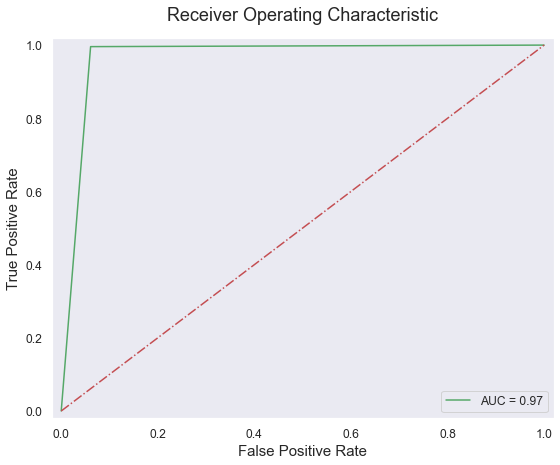

In [25]:
fpr, tpr, _ = roc_curve(y, y_pred) # Calculating FPR and TPR rate
roc_auc = auc(fpr, tpr)                 # Calculating area under ROC curve

plt.figure(figsize=(9,7))
plt.plot(fpr, tpr, 'g', label = f'AUC = {roc_auc:0.2f}')  # Plot AUC.
plt.legend(loc = 'lower right')

plt.plot([0, 1], [0, 1],'r-.')

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.title('Receiver Operating Characteristic', y = 1.03, fontsize=18)

plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)

plt.show()


## Any questions or suggestions are weclome???


### $\;\;\;$Note: 5 to 7 seconds silence is a No : )

# Thank you for unwavering attention throughout the presentation.